# Import library

In [1]:
# Library dasar
import os
import pathlib
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

# Library untuk image processing
import imageio
import cv2
from PIL import Image
from skimage import color, exposure
from skimage.filters import gaussian
import matplotlib.image as img

# TensorFlow dan Keras
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.utils import to_categorical

# Library untuk split data dan evaluasi
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Menonaktifkan warning
warnings.filterwarnings("ignore")


# Import data & load image

In [2]:
df = pd.read_csv('train.csv')

df.head()


,id,jenis,warna
0,1,1,1
1,2,0,2
2,3,1,3
3,4,1,1
4,5,0,4


In [3]:
train_images_path = 'train'  
image_size = (128, 128)

def load_images(df, images_path, image_size=(128, 128)):
    images = []
    labels_jenis = []
    labels_warna = []
    
    for index, row in df.iterrows():
        try:
            for ext in ['jpg', 'jpeg', 'png', 'JPG', 'JPEG', 'PNG']:
                img_path = os.path.join(images_path, f"{row['id']}.{ext}")
                if os.path.exists(img_path):
                    break
            else:
                print(f"Gambar untuk ID {row['id']} tidak ditemukan.")
            
            img = load_img(img_path, target_size=image_size)
            img_array = img_to_array(img) / 255.0  
            
            images.append(img_array)
            labels_jenis.append(row['jenis'])
            labels_warna.append(row['warna'])
        except FileNotFoundError:
            print(f"File not found: {img_path}, skipping...")
    
    return np.array(images), np.array(labels_jenis), np.array(labels_warna)



train_images, train_labels_jenis, train_labels_warna = load_images(df, train_images_path)


# Data exploration

## Jenis

Distribusi data berdasarkan jenis pakaian:
jenis
0    476
1    301
Name: count, dtype: int64

0: Kaos, 1: Hoodie


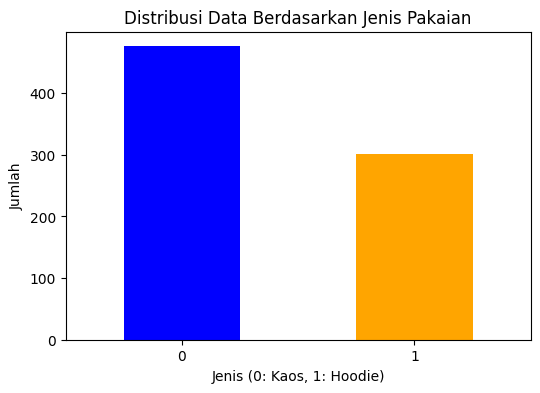

In [4]:
jenis_counts = df['jenis'].value_counts()

print("Distribusi data berdasarkan jenis pakaian:")
print(jenis_counts)
print("\n0: Kaos, 1: Hoodie")

plt.figure(figsize=(6, 4))
jenis_counts.plot(kind='bar', color=['blue', 'orange'])
plt.title('Distribusi Data Berdasarkan Jenis Pakaian')
plt.xlabel('Jenis (0: Kaos, 1: Hoodie)')
plt.ylabel('Jumlah')
plt.xticks(rotation=0)
plt.show()


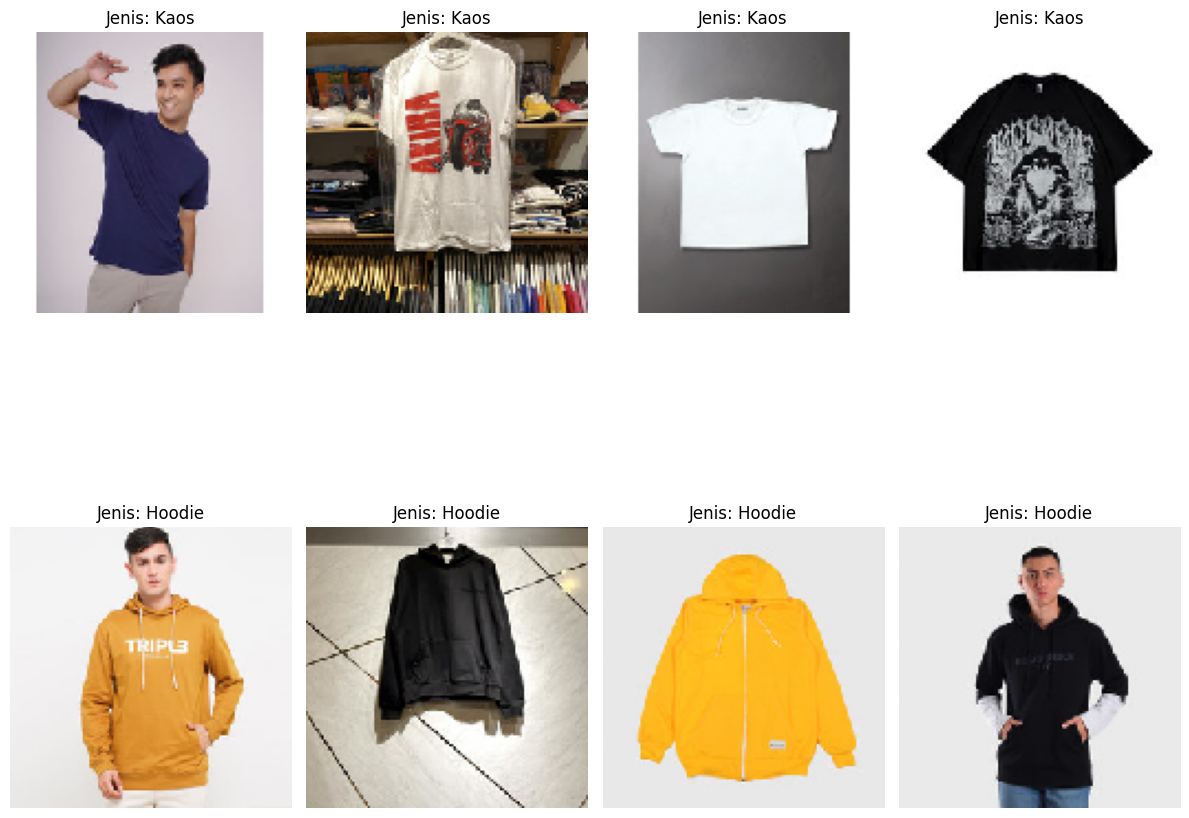

In [5]:
def plot_images_by_class(df, classes_to_display, n_images=4):
    plt.figure(figsize=(12, 12))
    
    for i, category in enumerate(classes_to_display):
        subset = df[df['jenis'] == category]
        
        for j in range(min(n_images, len(subset))): 
            img_id = subset.iloc[j]['id']
            img_formats = ['jpg', 'jpeg', 'png']  
            img_path = None
            
            for fmt in img_formats:
                potential_path = os.path.join(train_images_path, f"{img_id}.{fmt}")
                if os.path.isfile(potential_path):
                    img_path = potential_path
                    break
            
            if img_path is not None:
                img = load_img(img_path, target_size=(128, 128))
                img_array = img_to_array(img) / 255.0
                
                plt.subplot(len(classes_to_display), n_images, i * n_images + j + 1)
                plt.imshow(img_array)
                plt.title(f"Jenis: {'Kaos' if category == 0 else 'Hoodie'}")
                plt.axis('off')
            else:
                print(f"Gambar untuk ID {img_id} tidak ditemukan.")
    
    plt.tight_layout()
    plt.show()

plot_images_by_class(df, classes_to_display=[0, 1], n_images=4)

## Warna

Distribusi data berdasarkan warna pakaian:
warna
3    234
2    162
4    140
1    125
0    116
Name: count, dtype: int64

0: Merah, 1: Kuning, 2: Biru, 3: Hitam, 4: Putih


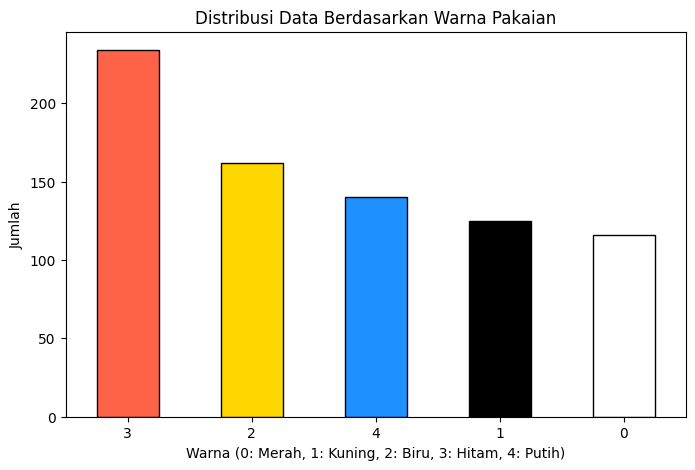

In [6]:
warna_counts = df['warna'].value_counts()

print("Distribusi data berdasarkan warna pakaian:")
print(warna_counts)
print("\n0: Merah, 1: Kuning, 2: Biru, 3: Hitam, 4: Putih")

colors = ['#FF6347', '#FFD700', '#1E90FF', '#000000', '#FFFFFF']

plt.figure(figsize=(8, 5))
bars = warna_counts.plot(kind='bar', color=colors, edgecolor='black')  
plt.title('Distribusi Data Berdasarkan Warna Pakaian')
plt.xlabel('Warna (0: Merah, 1: Kuning, 2: Biru, 3: Hitam, 4: Putih)')
plt.ylabel('Jumlah')
plt.xticks(rotation=0)
plt.show()


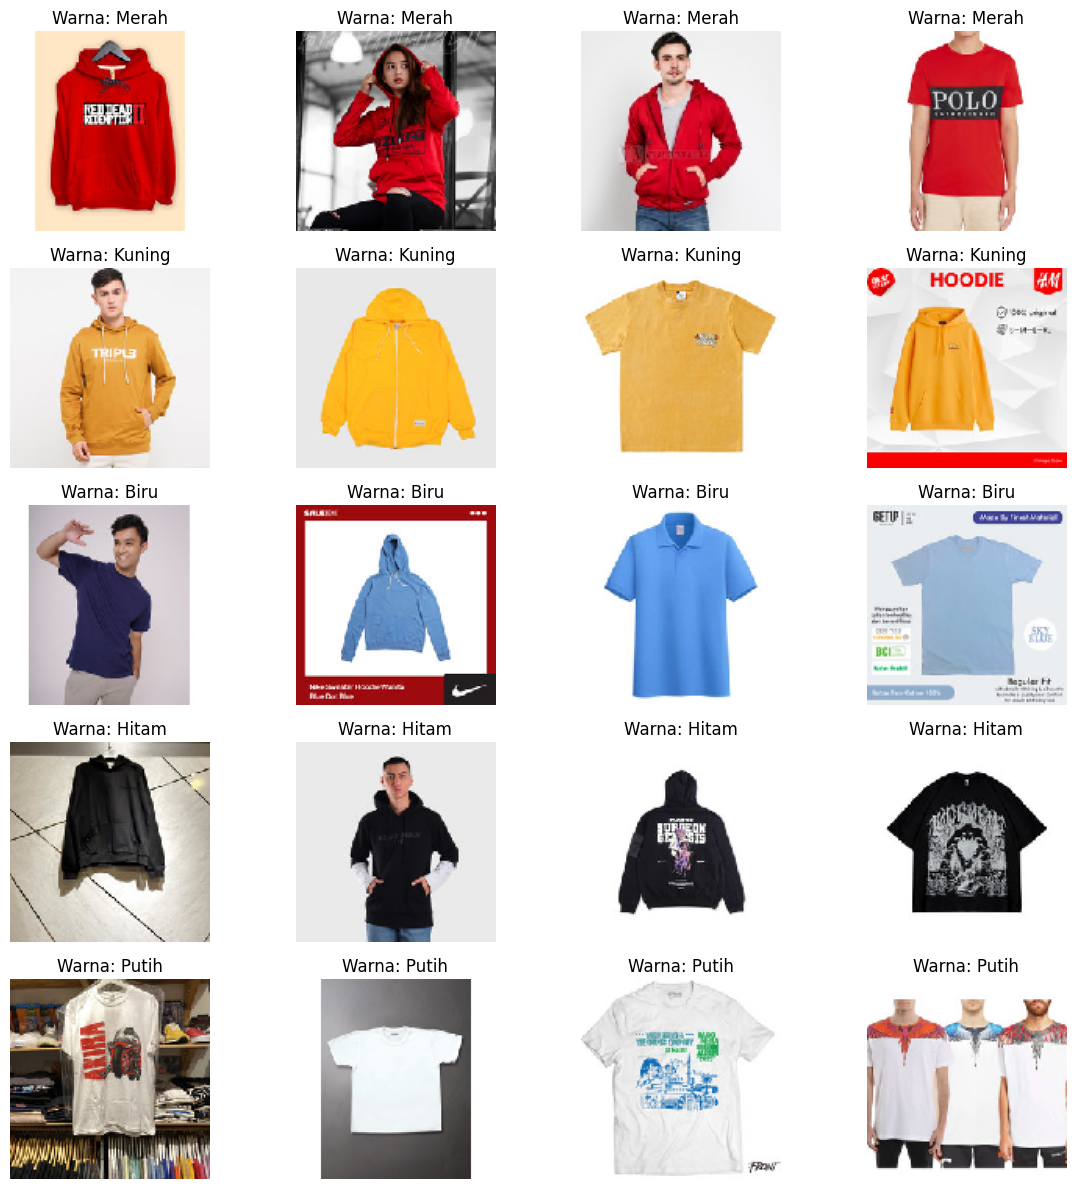

In [7]:
def plot_images_by_color(df, colors_to_display, n_images=4):
    plt.figure(figsize=(12, 12))
    
    color_names = {
        0: 'Merah',
        1: 'Kuning',
        2: 'Biru',
        3: 'Hitam',
        4: 'Putih'
    }
    
    for i, color in enumerate(colors_to_display):
        subset = df[df['warna'] == color]
        
        for j in range(min(n_images, len(subset))): 
            img_id = subset.iloc[j]['id']
            img_formats = ['jpg', 'jpeg', 'png']  
            img_path = None
            
            for fmt in img_formats:
                potential_path = os.path.join(train_images_path, f"{img_id}.{fmt}")
                if os.path.isfile(potential_path):
                    img_path = potential_path
                    break
            
            if img_path is not None:
                img = load_img(img_path, target_size=(128, 128))
                img_array = img_to_array(img) / 255.0
                
                plt.subplot(len(colors_to_display), n_images, i * n_images + j + 1)
                plt.imshow(img_array)
                plt.title(f"Warna: {color_names[color]}")
                plt.axis('off')
            else:
                print(f"Gambar untuk ID {img_id} tidak ditemukan.")
    
    plt.tight_layout()
    plt.show()

plot_images_by_color(df, colors_to_display=[0, 1, 2,3,4], n_images=4)

## Jenis dan Warna

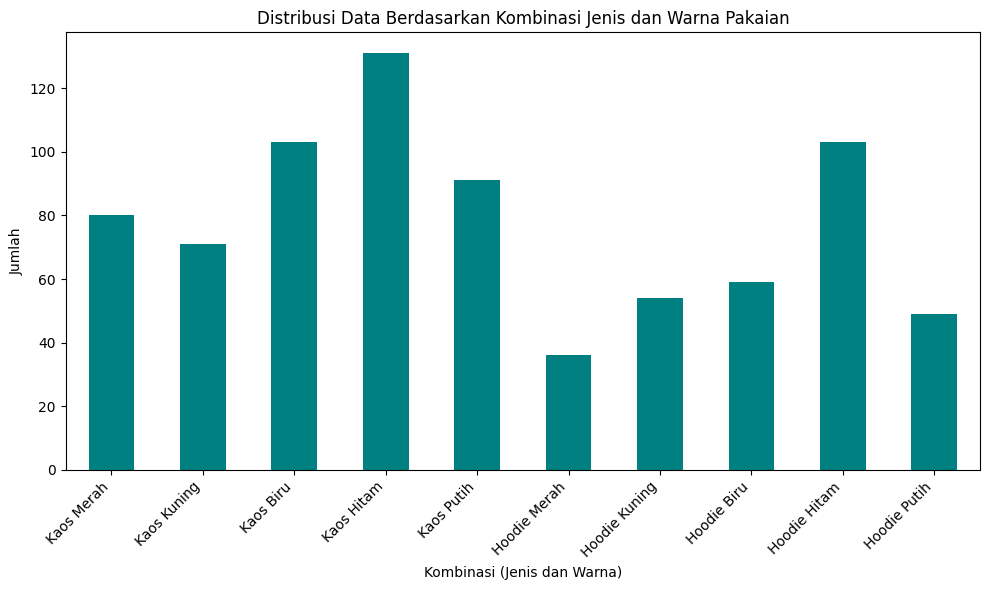

In [ ]:
df['kombinasi'] = df['jenis'].astype(str) + '_' + df['warna'].astype(str)

kombinasi_counts = df['kombinasi'].value_counts().sort_index()

jenis_mapping = {0: "Kaos", 1: "Hoodie"}
warna_mapping = {0: "Merah", 1: "Kuning", 2: "Biru", 3: "Hitam", 4: "Putih"}

kombinasi_counts.index = kombinasi_counts.index.map(
    lambda x: f"{jenis_mapping[int(x.split('_')[0])]} {warna_mapping[int(x.split('_')[1])]}"
)

plt.figure(figsize=(10, 6))
kombinasi_counts.plot(kind='bar', color='teal')
plt.title('Distribusi Data Berdasarkan Kombinasi Jenis dan Warna Pakaian')
plt.xlabel('Kombinasi (Jenis dan Warna)')
plt.ylabel('Jumlah')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


karena memang kaos jumlahnya lebih banyak, disini tidak ada kecenderungan/korelasi atara jenis dan warna

# **Jenis** 

In [8]:
df_jenis = df[['id', 'jenis']]
df_jenis.head()

,id,jenis
0,1,1
1,2,0
2,3,1
3,4,1
4,5,0


## Enhance

In [9]:
import cv2
import numpy as np
from tqdm import tqdm

def preprocess_images(images, clip_limit=0.03, gamma=1.5):
    enhanced_images = []
    
    for image in tqdm(images, desc="Preprocessing images", unit="image"):
        if image.dtype != np.uint8:
            image = (image * 255).astype(np.uint8)

        if len(image.shape) == 3 and image.shape[2] == 3:
            b, g, r = cv2.split(image)
            clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=(8, 8))
            b = clahe.apply(b)
            g = clahe.apply(g)
            r = clahe.apply(r)
            enhanced = cv2.merge((b, g, r))
        else:
            raise ValueError("Image must be in BGR format with 3 channels.")

        enhanced = np.power(enhanced / 255.0, gamma) * 255.0
        enhanced = enhanced.astype(np.uint8)

        kernel = np.array([[-1, -1, -1], [-1, 9, -1], [-1, -1, -1]])
        enhanced = cv2.filter2D(enhanced, -1, kernel)

        enhanced = cv2.fastNlMeansDenoisingColored(enhanced, None, 10, 7, 21)

        enhanced = cv2.normalize(enhanced, None, 0, 255, cv2.NORM_MINMAX)
        
        enhanced_images.append(enhanced)
    
    return np.array(enhanced_images)

x_train_enhanced = preprocess_images(train_images)

print("Shape gambar yang ditingkatkan:", x_train_enhanced.shape)  

Preprocessing images:   0%|          | 0/777 [00:00<?, ?image/s]

Preprocessing images: 100%|██████████| 777/777 [10:22<00:00,  1.25image/s]

Shape gambar yang ditingkatkan: (777, 128, 128, 3)


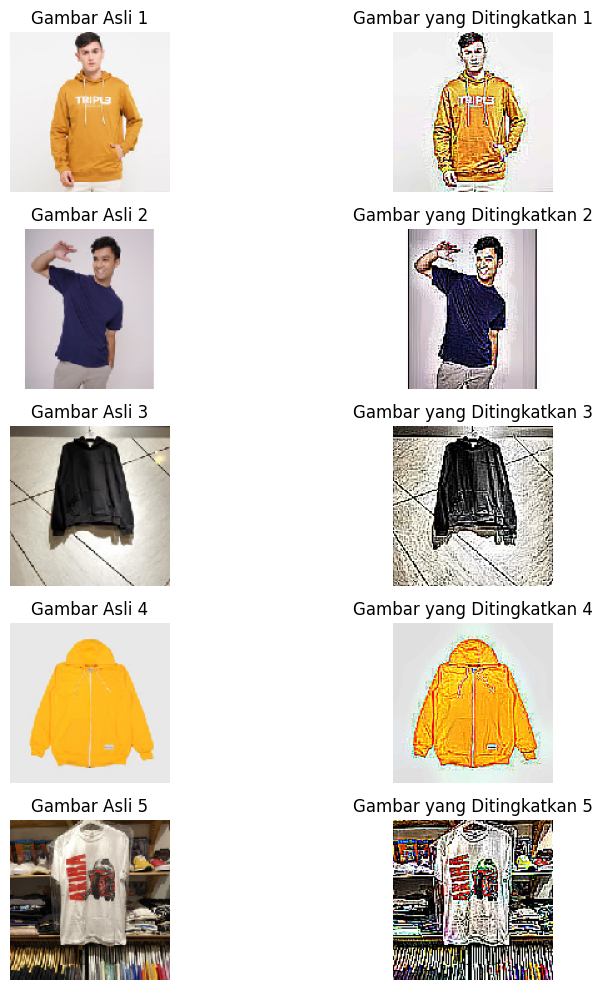

In [10]:
def plot_comparison(original_images, enhanced_images, num_images=5):
    fig, axes = plt.subplots(num_images, 2, figsize=(10, 2 * num_images))
    for i in range(num_images):
        axes[i, 0].imshow(original_images[i].squeeze())
        axes[i, 0].set_title(f'Gambar Asli {i+1}')
        axes[i, 0].axis('off')

        axes[i, 1].imshow(enhanced_images[i].squeeze())
        axes[i, 1].set_title(f'Gambar yang Ditingkatkan {i+1}')
        axes[i, 1].axis('off')
    plt.tight_layout()
    plt.show()

plot_comparison(train_images, x_train_enhanced, num_images=5)


## Split

In [11]:
X_train_jenis, X_val_jenis, y_train_jenis, y_val_jenis = train_test_split(
    x_train_enhanced, train_labels_jenis, test_size=0.2, random_state=42
)

## Modelling

In [12]:
def create_resnet_model(output_classes):
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

    for layer in base_model.layers:
        layer.trainable = False

    x = Flatten()(base_model.output)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(output_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)
    
    return model

model_jenis = create_resnet_model(2) 
model_jenis.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [13]:
history_jenis = model_jenis.fit(
    datagen.flow(X_train_jenis, y_train_jenis, batch_size=32),  
    epochs=50,
    validation_data=(X_val_jenis, y_val_jenis), 
    callbacks=[early_stopping]
)

Epoch 1/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 27s 804ms/step - accuracy: 0.6076 - loss: 9.8914 - val_accuracy: 0.7051 - val_loss: 3.5440
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 13s 642ms/step - accuracy: 0.7482 - loss: 2.9536 - val_accuracy: 0.8013 - val_loss: 0.3526
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 13s 651ms/step - accuracy: 0.7334 - loss: 0.5831 - val_accuracy: 0.8333 - val_loss: 0.3661
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 13s 641ms/step - accuracy: 0.7687 - loss: 0.4788 - val_accuracy: 0.8910 - val_loss: 0.3264
Epoch 5/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 13s 644ms/step - accuracy: 0.8010 - loss: 0.3798 - val_accuracy: 0.8205 - val_loss: 0.3105
Epoch 6/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 13s 641ms/step - accuracy: 0.8010 - loss: 0.4389 - val_accuracy: 0.9038 - val_loss: 0.3105
Epoch 7/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 13s 629ms/step - accuracy: 0.8114 - loss: 0.3828 - val_accuracy: 0.8590 - val_loss: 0.3764
Epoch 8/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 13s 650ms/step - accuracy: 0.7881 - loss: 0.3983 - val_accu

## Eval

5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 510ms/step - accuracy: 0.9335 - loss: 0.1995
Loss: 0.2198, Accuracy: 0.9295
5/5 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step  
              precision    recall  f1-score   support

        Kaos       0.94      0.95      0.95       101
      Hoodie       0.91      0.89      0.90        55

    accuracy                           0.93       156
   macro avg       0.92      0.92      0.92       156
weighted avg       0.93      0.93      0.93       156



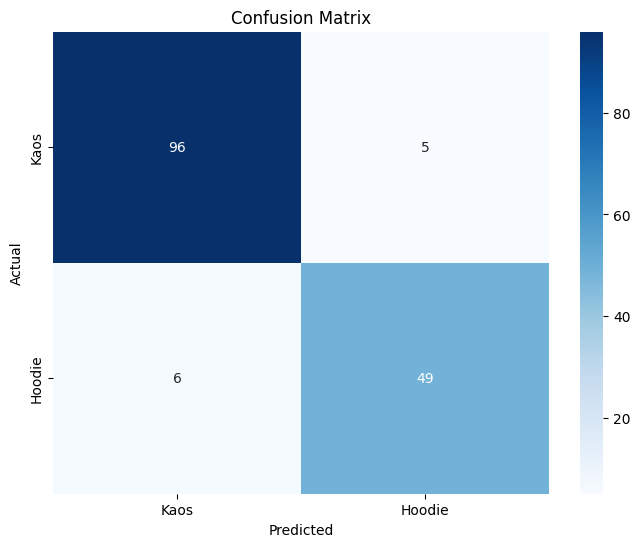

In [14]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

loss_jenis, accuracy_jenis = model_jenis.evaluate(X_val_jenis, y_val_jenis)
print(f"Loss: {loss_jenis:.4f}, Accuracy: {accuracy_jenis:.4f}")

y_pred_jenis = model_jenis.predict(X_val_jenis)
y_pred_classes = np.argmax(y_pred_jenis, axis=1)  # Kelas yg probabilitas tertinggi

report = classification_report(y_val_jenis, y_pred_classes, target_names=['Kaos', 'Hoodie'])
print(report)

conf_matrix = confusion_matrix(y_val_jenis, y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Kaos', 'Hoodie'], yticklabels=['Kaos', 'Hoodie'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

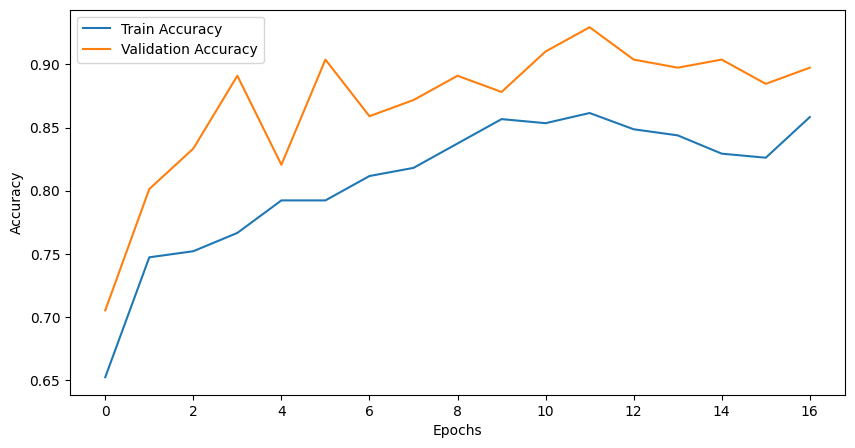

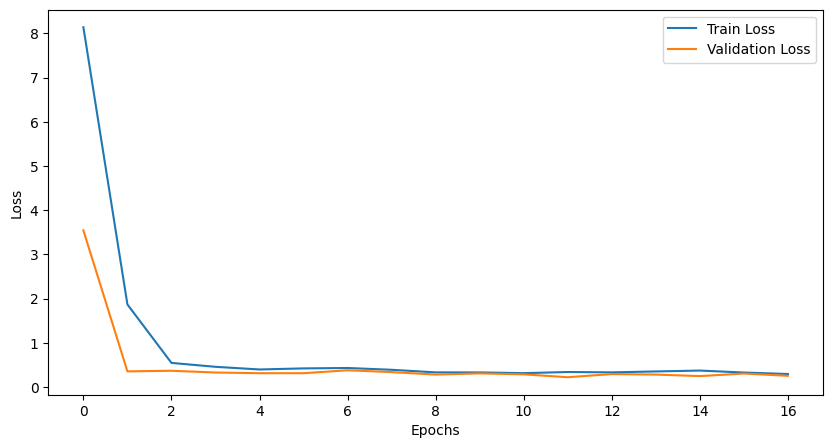

In [15]:
# Plot accuracy
plt.figure(figsize=(10, 5))
plt.plot(history_jenis.history['accuracy'], label='Train Accuracy')
plt.plot(history_jenis.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot loss
plt.figure(figsize=(10, 5))
plt.plot(history_jenis.history['loss'], label='Train Loss')
plt.plot(history_jenis.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [16]:
if y_val_jenis.ndim > 1:
    y_val_jenis = np.argmax(y_val_jenis, axis=1)


In [17]:
y_val_jenis = np.array(y_val_jenis)

In [18]:
y_pred_jenis = model_jenis.predict(X_val_jenis)

y_prediction_classes = np.argmax(y_pred_jenis, axis=1)


5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 498ms/step


In [19]:
accuracy = np.sum(y_prediction_classes == y_val_jenis) / len(y_val_jenis)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.9295


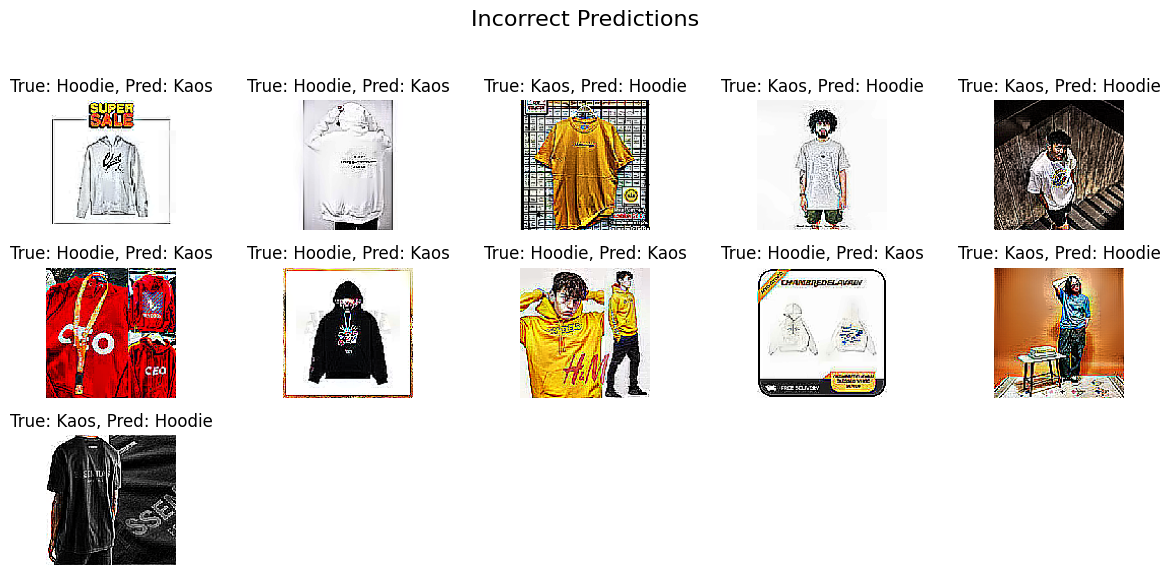

In [20]:
incorrect_indices = np.where(y_prediction_classes != y_val_jenis)[0]
class_names = ['Kaos', 'Hoodie']

plt.figure(figsize=(12, 6))
plt.suptitle("Incorrect Predictions", fontsize=16)

for i in range(min(15, len(incorrect_indices))): 
    plt.subplot(3, 5, i + 1)
    plt.imshow(X_val_jenis[incorrect_indices[i]].squeeze(), cmap='gray') 
    plt.title(f"True: {class_names[y_val_jenis[incorrect_indices[i]]]}, Pred: {class_names[y_prediction_classes[incorrect_indices[i]]]}")    
    plt.axis('off')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


## Test

In [21]:
def load_test_images(df, images_path, image_size=(128, 128)):
    images = []
    labels = []
    
    for index, row in df.iterrows():
        img_id = row['id']
        img_formats = ['jpg', 'jpeg', 'png']
        img_path = None
        
        for fmt in img_formats:
            potential_path = os.path.join(images_path, f"{img_id}.{fmt}")
            if os.path.isfile(potential_path):
                img_path = potential_path
                break
        
        if img_path is not None:
            img = load_img(img_path, target_size=image_size)
            img_array = img_to_array(img) / 255.0  
            images.append(img_array)
            labels.append(row['jenis'] if 'jenis' in row else row['warna'])
        else:
            print(f"Gambar untuk ID {img_id} tidak ditemukan.")
    
    return np.array(images), np.array(labels)

df_test = pd.read_csv("sample_submission.csv") 
df_test = df_test[['id', 'jenis']]

test_images_path = 'test'
test_images_jenis, test_labels_jenis = load_test_images(df_test, test_images_path)

# Prepro
x_test_enhanced = preprocess_images(test_images_jenis)

print("Data pengujian siap:", x_test_enhanced.shape, test_labels_jenis.shape)

# Prediksi
y_pred_prob = model_jenis.predict(x_test_enhanced)
y_pred_classes = np.argmax(y_pred_prob, axis=1)  # ambil kelas yg probabilitasnya tertinggi


results_df = pd.DataFrame({
    'id': df_test['id'],
    'jenis': y_pred_classes  
})


# results_df.to_csv('predictions_jenis1.csv', index=False)
print("Hasil prediksi telah disimpan ke 'predictions_jenis.csv'")


Preprocessing images: 100%|██████████| 334/334 [04:32<00:00,  1.23image/s]


Data pengujian siap: (334, 128, 128, 3) (334,)
11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 468ms/step
Hasil prediksi telah disimpan ke 'predictions_jenis.csv'


In [22]:
results_df

,id,jenis
0,778,0
1,779,1
2,780,1
3,781,0
4,782,1
...,...,...
329,1107,1
330,1108,0
331,1109,0
332,1110,1


# Warna

In [23]:
def load_images(df, images_path, image_size=(128, 128)):
    images = []
    labels = []
    
    for index, row in df.iterrows():
        img_id = row['id']
        img_formats = ['jpg', 'jpeg', 'png']
        img_path = None
        
        for fmt in img_formats:
            potential_path = os.path.join(images_path, f"{img_id}.{fmt}")
            if os.path.isfile(potential_path):
                img_path = potential_path
                break
        
        if img_path is not None:
            img = load_img(img_path, target_size=image_size)
            img_array = img_to_array(img) / 255.0  # Normalisasi gambar
            images.append(img_array)
            labels.append(row['jenis'] if 'jenis' in row else row['warna'])
        else:
            print(f"Gambar untuk ID {img_id} tidak ditemukan.")
    
    return np.array(images), np.array(labels)


In [24]:
train_images_jenis, train_labels_jenis = load_images(df_jenis, train_images_path)


In [25]:
def load_images(df, images_path, image_size=(128, 128), saturation_scale=1.5):
    images = []
    labels = []
    
    for index, row in df.iterrows():
        img_id = row['id']
        img_formats = ['jpg', 'jpeg', 'png']
        img_path = None
        
        for fmt in img_formats:
            potential_path = os.path.join(images_path, f"{img_id}.{fmt}")
            if os.path.isfile(potential_path):
                img_path = potential_path
                break
        
        if img_path is not None:
            img = load_img(img_path, target_size=image_size)
            img_array = img_to_array(img) / 255.0 
            
            # kontras
            img_array = exposure.adjust_gamma(img_array, gamma=1.5) 
            
            # Blur
            img_array = gaussian(img_array, sigma=1)  

            # Saturasi
            img_array_hsv = cv2.cvtColor((img_array * 255).astype(np.uint8), cv2.COLOR_RGB2HSV)  # Konversi ke HSV
            img_array_hsv[..., 1] = np.clip(img_array_hsv[..., 1] * saturation_scale, 0, 255)  # Ningktin saturasi
            img_array = cv2.cvtColor(img_array_hsv, cv2.COLOR_HSV2RGB) / 255.0  # Kembali ke RGB dan normalisasi
            
            images.append(img_array)
            labels.append(row['warna'])  # Ambil label warna
        else:
            print(f"Gambar untuk ID {img_id} tidak ditemukan.")
    
    return np.array(images), np.array(labels)


In [26]:
train_df = pd.read_csv('train.csv')  
train_images_path = 'train'

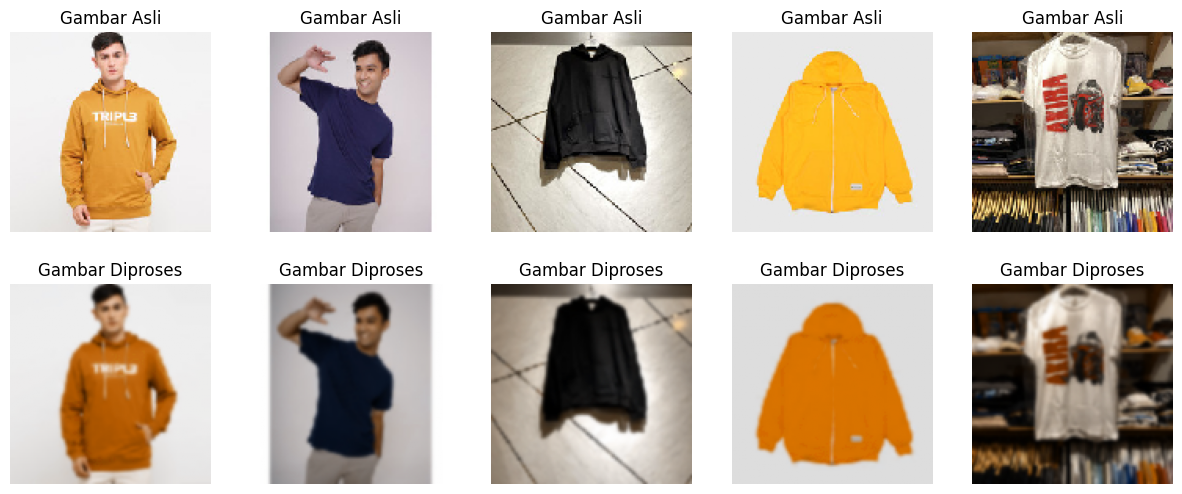

In [27]:

def display_images(original_images, processed_images, n=5):
    plt.figure(figsize=(15, 6))
    
    for i in range(n):
        plt.subplot(2, n, i + 1)
        plt.imshow(original_images[i])
        plt.axis('off')
        plt.title('Gambar Asli')

        plt.subplot(2, n, i + 1 + n)
        plt.imshow(processed_images[i])
        plt.axis('off')
        plt.title('Gambar Diproses')

    plt.show()


images, labels = load_images(train_df, train_images_path)
labels = to_categorical(labels, num_classes=5) 

display_images(train_images_jenis, images, n=5)  


## Split

In [28]:
X = images
y = labels

X_train_warna, X_val_warna, y_train_warna, y_val_warna = train_test_split(X, y, test_size=0.2, random_state=42, stratify=np.argmax(y, axis=1))

## Modelling

In [52]:
def create_model_warna(input_shape=(128, 128, 3)):
    model = Sequential()
    
    # Lapisan konvolusi pertama
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2)))  
    
    # Lapisan konvolusi kedua
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))  
    
    # Lapisan konvolusi ketiga
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))  

    # Rata-rata lapisan dan dense
    model.add(Flatten())  
    model.add(Dense(128, activation='relu'))  
    model.add(Dropout(0.5))
    model.add(Dense(5, activation='softmax'))  
    
    return model

model_warna = create_model_warna()

model_warna.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

history_warna = model_warna.fit(datagen.flow(X_train_warna, y_train_warna, batch_size=32),  # Gunakan datagen untuk augmentasi
                                  epochs=50, 
                                  steps_per_epoch=len(X_train_warna) // 32, 
                                  validation_data=(X_val_warna, y_val_warna),
                                  callbacks=[early_stopping])  # Tambahkan EarlyStopping di sini


Epoch 1/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 9s 323ms/step - accuracy: 0.3122 - loss: 1.5690 - val_accuracy: 0.7436 - val_loss: 0.7351
Epoch 2/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6875 - loss: 0.8218 - val_accuracy: 0.7756 - val_loss: 0.6772
Epoch 3/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 299ms/step - accuracy: 0.7213 - loss: 0.6975 - val_accuracy: 0.8397 - val_loss: 0.5159
Epoch 4/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.7812 - loss: 0.9384 - val_accuracy: 0.8590 - val_loss: 0.4778
Epoch 5/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 308ms/step - accuracy: 0.8458 - loss: 0.4629 - val_accuracy: 0.8846 - val_loss: 0.3210
Epoch 6/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.8750 - loss: 0.3144 - val_accuracy: 0.8910 - val_loss: 0.2950
Epoch 7/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 299ms/step - accuracy: 0.8455 - loss: 0.4233 - val_accuracy: 0.8654 - val_loss: 0.3644
Epoch 8/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.8750 - loss: 0.3478 - val_accuracy: 0.9038

## Eval

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9746 - loss: 0.0714
Loss: 0.0962, Accuracy: 0.9615
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step
              precision    recall  f1-score   support

       Merah       0.96      0.96      0.96        23
      Kuning       1.00      1.00      1.00        25
        Biru       0.91      0.97      0.94        33
       Hitam       0.98      0.98      0.98        47
       Putih       0.96      0.89      0.93        28

    accuracy                           0.96       156
   macro avg       0.96      0.96      0.96       156
weighted avg       0.96      0.96      0.96       156



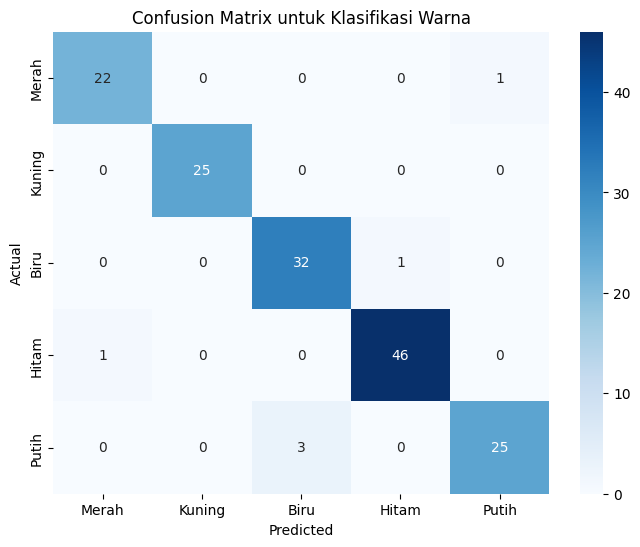

In [53]:
loss_warna, accuracy_warna = model_warna.evaluate(X_val_warna, y_val_warna)
print(f"Loss: {loss_warna:.4f}, Accuracy: {accuracy_warna:.4f}")


y_pred_warna = model_warna.predict(X_val_warna)
y_pred_classes = np.argmax(y_pred_warna, axis=1)  

y_val_classes = np.argmax(y_val_warna, axis=1)
report = classification_report(y_val_classes, y_pred_classes, 
                               target_names=['Merah', 'Kuning', 'Biru', 'Hitam', 'Putih'])
print(report)


conf_matrix = confusion_matrix(y_val_classes, y_pred_classes)


plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Merah', 'Kuning', 'Biru', 'Hitam', 'Putih'], 
            yticklabels=['Merah', 'Kuning', 'Biru', 'Hitam', 'Putih'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix untuk Klasifikasi Warna')
plt.show()

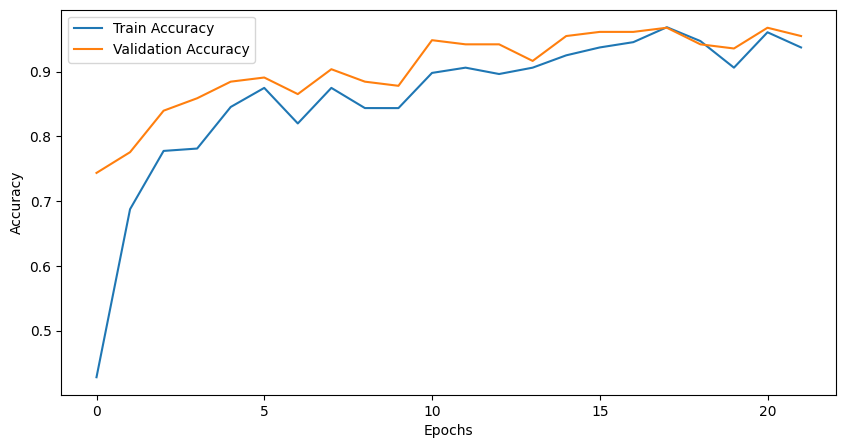

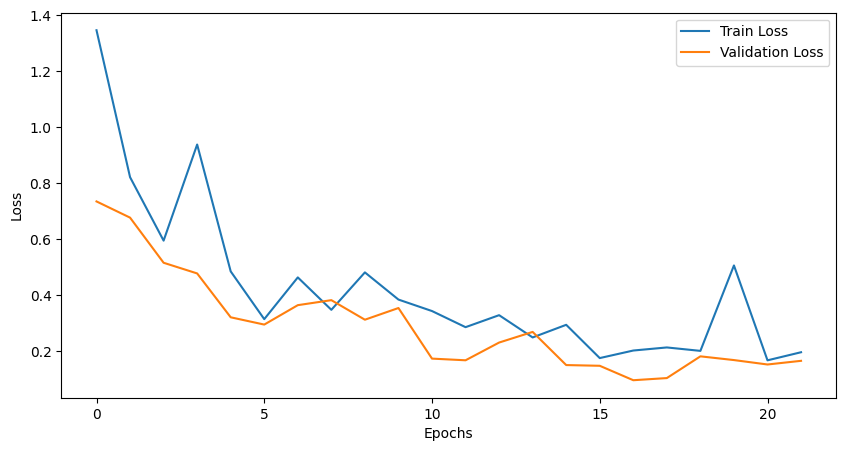

In [54]:
# Plot accuracy
plt.figure(figsize=(10, 5))
plt.plot(history_warna.history['accuracy'], label='Train Accuracy')
plt.plot(history_warna.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot loss
plt.figure(figsize=(10, 5))
plt.plot(history_warna.history['loss'], label='Train Loss')
plt.plot(history_warna.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [55]:
predictions = model_warna.predict(X_val_warna)

predicted_classes = np.argmax(predictions, axis=1)

true_classes = np.argmax(y_val_warna, axis=1)

print(classification_report(true_classes, predicted_classes, 
                            target_names=['Merah', 'Kuning', 'Biru', 'Hitam', 'Putih']))


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
              precision    recall  f1-score   support

       Merah       0.96      0.96      0.96        23
      Kuning       1.00      1.00      1.00        25
        Biru       0.91      0.97      0.94        33
       Hitam       0.98      0.98      0.98        47
       Putih       0.96      0.89      0.93        28

    accuracy                           0.96       156
   macro avg       0.96      0.96      0.96       156
weighted avg       0.96      0.96      0.96       156



In [56]:
true_classes = np.argmax(y_val_warna, axis=1)  
y_prediction_classes = np.argmax(y_pred_warna, axis=1)  
incorrect_indices = np.where(y_prediction_classes != true_classes)[0]

print("Indeks dari prediksi yang salah:", incorrect_indices)


Indeks dari prediksi yang salah: [ 56  78 100 108 111 141]


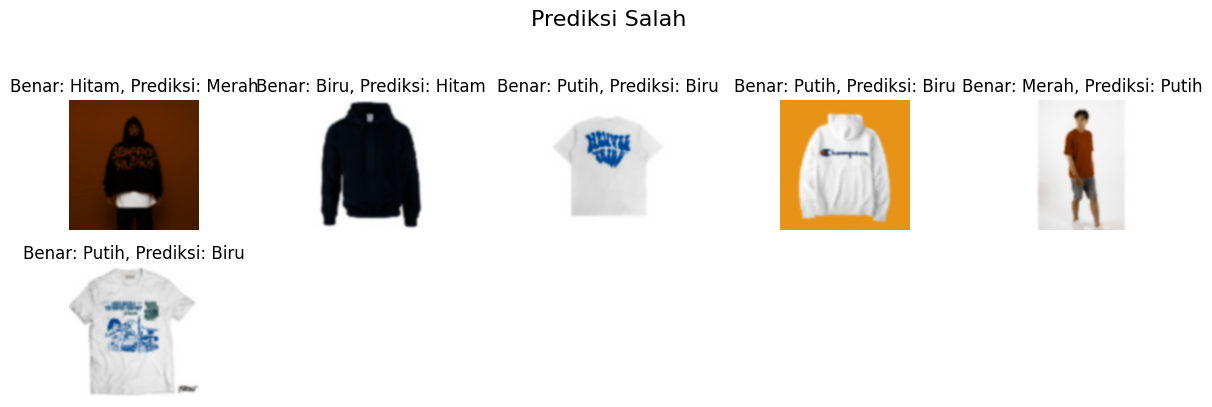

In [57]:
class_names = ['Merah', 'Kuning', 'Biru', 'Hitam', 'Putih']

true_classes_warna = np.argmax(y_val_warna, axis=1)  
plt.figure(figsize=(12, 6))
plt.suptitle("Prediksi Salah", fontsize=16)

for i in range(min(15, len(incorrect_indices))): 
    plt.subplot(3, 5, i + 1)
    plt.imshow(X_val_warna[incorrect_indices[i]])  
    plt.title(f"Benar: {class_names[true_classes_warna[incorrect_indices[i]]]}, Prediksi: {class_names[y_prediction_classes[incorrect_indices[i]]]}")  # Menampilkan judul
    plt.axis('off')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


## Test

In [58]:
def load_test_images(df, images_path, image_size=(128, 128), saturation_scale=1.5):
    images = []
    
    for index, row in df.iterrows():
        img_id = row['id']
        img_formats = ['jpg', 'jpeg', 'png']
        img_path = None
        
        for fmt in img_formats:
            potential_path = os.path.join(images_path, f"{img_id}.{fmt}")
            if os.path.isfile(potential_path):
                img_path = potential_path
                break
        
        if img_path is not None:
            img = load_img(img_path, target_size=image_size)
            img_array = img_to_array(img) / 255.0  
            
            img_array = exposure.adjust_gamma(img_array, gamma=1.5)  
            
            img_array = gaussian(img_array, sigma=1)  

            img_array_hsv = cv2.cvtColor((img_array * 255).astype(np.uint8), cv2.COLOR_RGB2HSV)  # Konversi ke HSV
            img_array_hsv[..., 1] = np.clip(img_array_hsv[..., 1] * saturation_scale, 0, 255)  # Tingkatkan saturasi
            img_array = cv2.cvtColor(img_array_hsv, cv2.COLOR_HSV2RGB) / 255.0  # Kembali ke RGB dan normalisasi
            
            images.append(img_array)
        else:
            print(f"Gambar untuk ID {img_id} tidak ditemukan.")
    
    return np.array(images)


test_images_path = 'test'  
X_test = load_test_images(df_test, test_images_path)

predictions = model_warna.predict(X_test)

predicted_classes = np.argmax(predictions, axis=1)



11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step


# Marged

In [59]:
results_df['warna'] = predicted_classes

In [60]:
results_df

,id,jenis,warna
0,778,0,3
1,779,1,3
2,780,1,2
3,781,0,1
4,782,1,3
...,...,...,...
329,1107,1,0
330,1108,0,2
331,1109,0,2
332,1110,1,3


In [64]:
results_df.to_csv('predictions2.csv', index=False)
